## 1. Import packages and define data directory

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

import scipy.stats as st
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

In [2]:
data_dir = "../input/" # Uncomment this line if you work on local computer
# data_dir = '/kaggle/input/eee-datathon-challenge-2020/' # Comment this line if you work on local computer

## 2. Import Train dataset

In [3]:
diamonds = pd.read_csv(data_dir+"train.csv",index_col = False)
# diamonds = pd.read_csv("train.csv",index_col = False)
diamonds.head() # display the data on the top of the table

,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,27454,1.70,Very Good,E,VS2,58.6,60.0,18107,7.91,7.82,4.61
1,38353,0.47,Very Good,F,SI1,61.1,61.0,1021,4.97,5.01,3.05
2,2675,0.70,Good,D,VS1,57.8,60.0,3239,5.85,5.87,3.39
3,15280,1.50,Premium,I,SI2,62.9,57.0,6132,7.28,7.26,4.57
4,49324,0.51,Ideal,F,VVS2,62.2,56.0,2093,5.08,5.12,3.17


In [4]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
id         43152 non-null int64
carat      43152 non-null float64
cut        43152 non-null object
color      43152 non-null object
clarity    43152 non-null object
depth      43152 non-null float64
table      43152 non-null float64
price      43152 non-null int64
x          43152 non-null float64
y          43152 non-null float64
z          43152 non-null float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [5]:
# Price is int64, best if all numeric attributes have the same datatype, especially as float64
diamonds["price"] = diamonds["price"].astype(float)

# Preview dataset again
diamonds.head()

,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,27454,1.70,Very Good,E,VS2,58.6,60.0,18107.0,7.91,7.82,4.61
1,38353,0.47,Very Good,F,SI1,61.1,61.0,1021.0,4.97,5.01,3.05
2,2675,0.70,Good,D,VS1,57.8,60.0,3239.0,5.85,5.87,3.39
3,15280,1.50,Premium,I,SI2,62.9,57.0,6132.0,7.28,7.26,4.57
4,49324,0.51,Ideal,F,VVS2,62.2,56.0,2093.0,5.08,5.12,3.17


## 3. Data Visualization

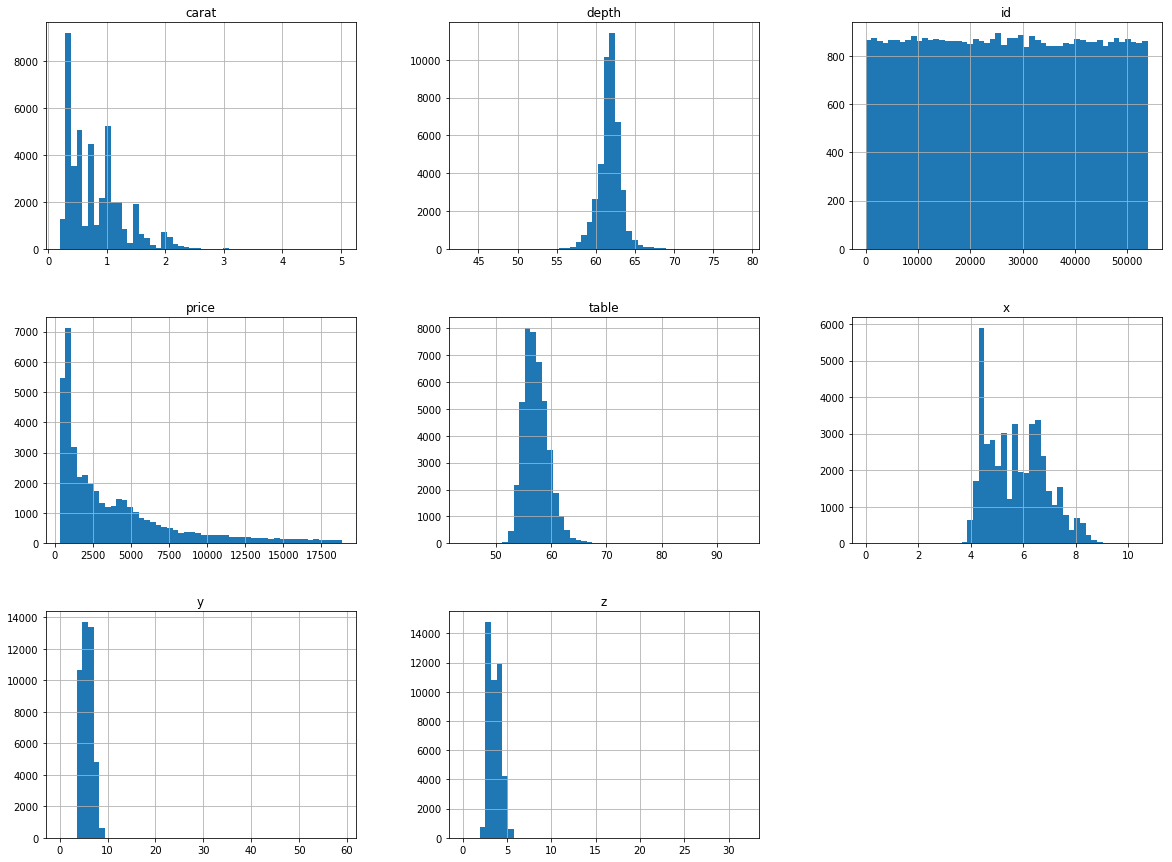

In [6]:
#  Have a rough idea on the distribution of each attributes 
#  X stands for the value and Y stands for the amount
diamonds.hist(bins = 50, figsize = (20, 15))
plt.show()

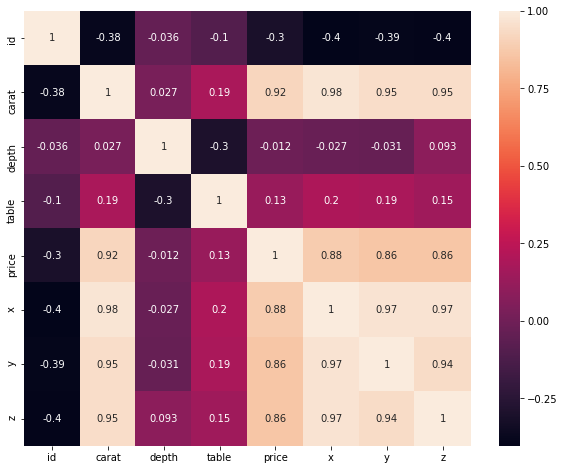

In [7]:
# Create a correlation matrix between every pair of attributes and try to find the relationship between them
corr_matrix = diamonds.corr()
plt.subplots(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True)
plt.show()

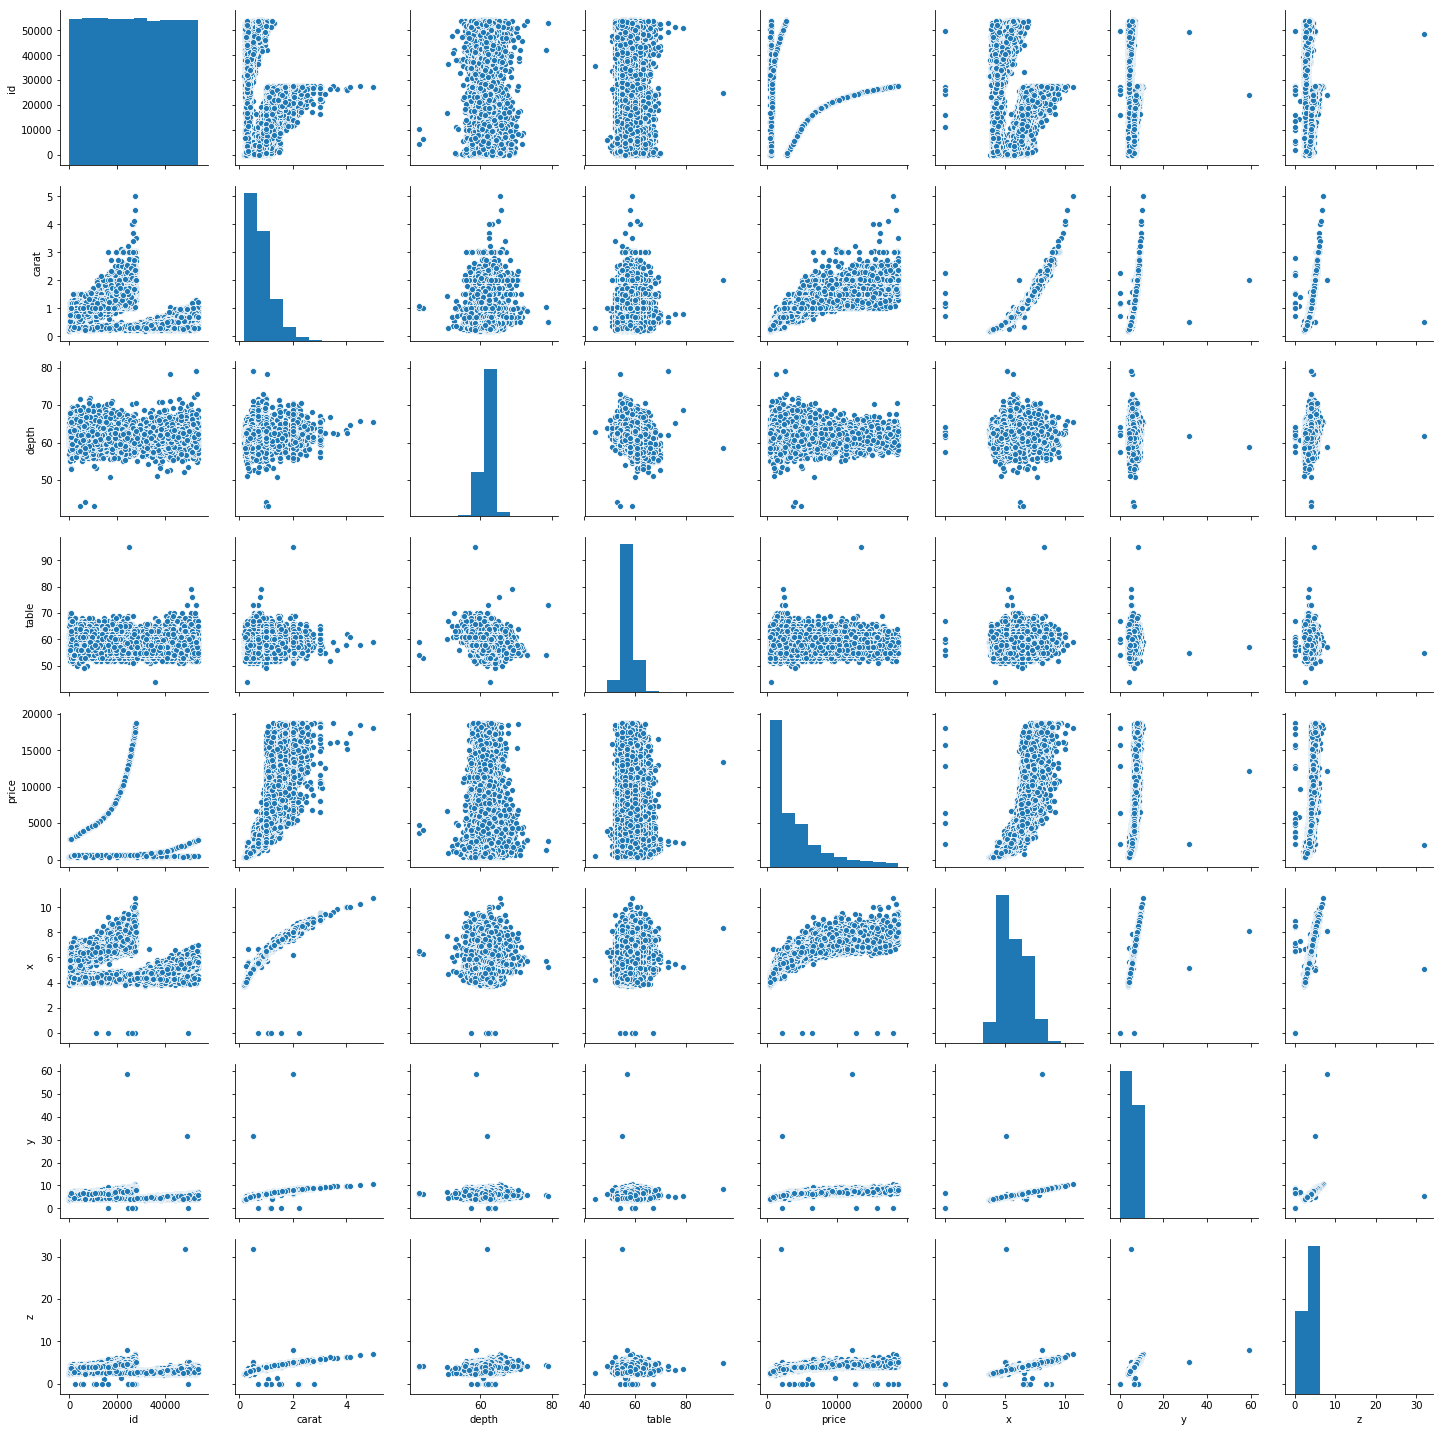

In [8]:
# See the relationship  of every pair of attributes
sns.pairplot(data = diamonds)

/home/melvinkokxw/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


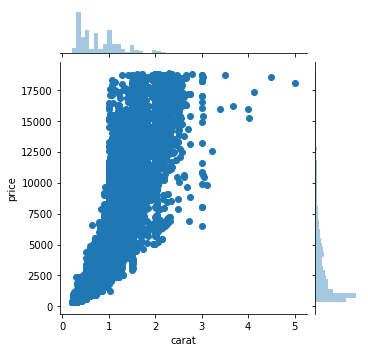

In [9]:
# Show the relationship between price and carat
sns.jointplot(x='carat' , y='price' , data=diamonds , size=5)

/home/melvinkokxw/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


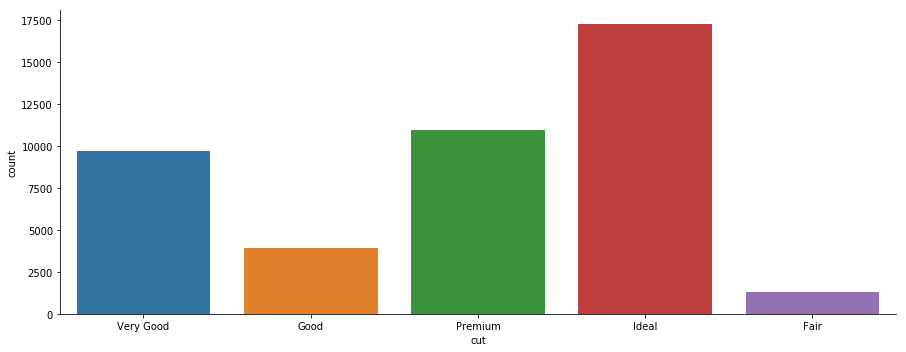

In [10]:
# Count the number of diffent cut
sns.factorplot(x='cut', data=diamonds , kind='count',aspect=2.5 )

/home/melvinkokxw/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


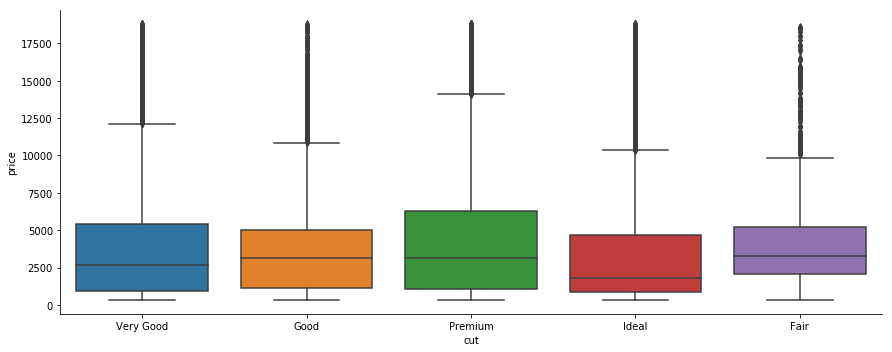

In [11]:
# Show the relationship between price and quality
sns.factorplot(x='cut', y='price', data=diamonds, kind='box' ,aspect=2.5 )

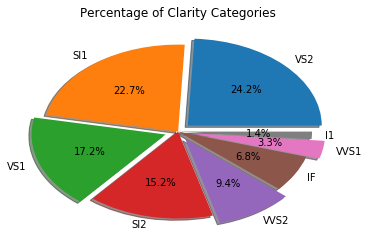

In [12]:
# Show the percentage of Clarity Categories
labels = diamonds.clarity.unique().tolist()
sizes = diamonds.clarity.value_counts().tolist()
explode = (0.1, 0.0, 0.1, 0, 0.1, 0, 0.1,0)
plt.pie(sizes, explode=explode, labels=labels,autopct='%1.1f%%', shadow=True)
plt.title("Percentage of Clarity Categories")
plt.plot()
plt.show()

/home/melvinkokxw/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


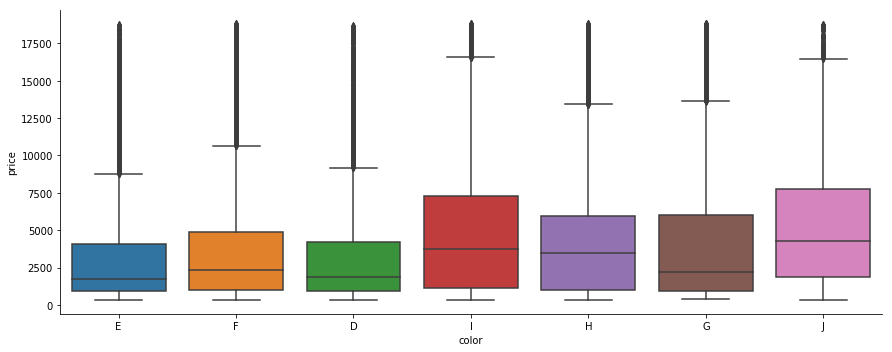

In [13]:
# Show the relationship between price and clarity
sns.factorplot(x='color', y='price', data=diamonds, kind='box' ,aspect=2.5 )

## 4. Process Train dataset

In [14]:
scaler = StandardScaler()
# Drop categorical (non-numeric) columns.
diamonds_num = diamonds.drop(["cut", "color", "clarity"], axis = 1)

### Convert categorical data to One Hot Encoding

In [15]:
hot = OneHotEncoder(sparse=False)
diamonds_cat = diamonds[["cut", "color", "clarity"]]
diamonds_cat.head()

,cut,color,clarity
0,Very Good,E,VS2
1,Very Good,F,SI1
2,Good,D,VS1
3,Premium,I,SI2
4,Ideal,F,VVS2


In [16]:
diamonds_cat_hot = hot.fit_transform(diamonds_cat)

# Output type of a fit_transform is ndarray so we need to convert it back to DataFrame
diamonds_cat_hot = pd.DataFrame(diamonds_cat_hot,index=diamonds_cat.index)
diamonds_cat_hot.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Combine categorical and numerical data

In [17]:
# Concat both DataFrames
diamonds_ready = pd.concat([diamonds_num,diamonds_cat_hot],axis=1)
diamonds_ready.head()

,id,carat,depth,table,price,x,y,z,0,1,...,10,11,12,13,14,15,16,17,18,19
0,27454,1.70,58.6,60.0,18107.0,7.91,7.82,4.61,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,38353,0.47,61.1,61.0,1021.0,4.97,5.01,3.05,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2675,0.70,57.8,60.0,3239.0,5.85,5.87,3.39,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,15280,1.50,62.9,57.0,6132.0,7.28,7.26,4.57,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,49324,0.51,62.2,56.0,2093.0,5.08,5.12,3.17,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 5. Train and evaluate the model

In [18]:
seed = 211197
X_train, X_test, y_train, y_test = train_test_split(diamonds_ready.drop('price',axis=1),diamonds_ready['price'], test_size=0.25, random_state=seed)

In [19]:
parameters = {'n_estimators'       : st.randint(1000, 5000),
              'max_depth'          : st.randint(1, 20),
              'learning_rate'      : st.uniform(0.001, 0.1),
              'colsample_bytree'   : st.beta(10, 1),
              'subsample'          : st.beta(10, 1),
              'gamma'              : st.uniform(0, 10),
              'min_child_weight'   : st.expon(0, 10)}

model = RandomizedSearchCV(xgb.XGBRegressor(booster='gbtree',objective='reg:linear'), parameters, scoring='r2', cv=KFold(n_splits=5, random_state=1, shuffle=True), n_jobs=1, n_iter=100, random_state=seed)
model.fit(X_train,y_train)

# Evaluate model using train set
train_r2 = model.score(X_train,y_train) #R^2 score
pred = model.predict(X_train)
train_mse = mean_squared_error(y_train,pred)
print('train_r2:  ', train_r2)
print('train_mse: ', train_mse)

# Evaluate model using train set
test_r2 = model.score(X_test,y_test) # R^2 score
pred_test = model.predict(X_test)
test_mse = mean_squared_error(y_test,pred_test)
print('test_r2:   ', test_r2)
print('test_mse:  ', test_mse)

[07:54:49] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:03] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[07:57:05] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:15] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:17] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:26] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[08:01:28] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[08:03:40] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[08:49:40] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:40] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[08:50:55] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[08:50:56] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:11] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:12] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:34] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:35] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[09:32:24] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:47] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:47] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:35:08] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:35:09] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:36:31] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:36:32] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:37:52] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[09:55:42] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:55:42] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:55:52] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:55:52] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:56:02] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:56:02] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:56:14] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[09:56:14] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[10:07:05] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:26] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:27] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:48] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:49] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:10] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:10] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:32] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[10:23:01] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:01] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:26] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:27] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:52] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:52] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:17] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:17] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[10:54:09] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:27] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:28] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:46] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:54:46] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:55:04] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:55:04] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[10:55:22] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[11:24:18] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:18] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:26] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:26] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:34] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:34] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:56] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:56] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[11:50:22] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:50:45] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:50:46] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:09] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:09] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:36] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:36] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:59] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[12:16:38] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:39] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:17:26] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:17:27] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:13] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:14] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:54] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:54] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[12:49:05] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:50:11] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:50:12] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:18] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:19] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:52:25] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:52:26] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:33] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[13:08:11] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:11] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:24] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:24] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:36] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:36] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:52] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:52] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[13:28:09] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:58] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:58] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:47] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:48] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:30:36] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:30:36] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:24] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[14:00:36] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:00:37] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:01:23] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:01:24] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:10] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:10] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:39] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:39] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[14:23:43] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:11] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:12] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:40] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:40] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:08] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:08] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:25:36] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

[14:53:08] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:08] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:26] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:26] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:45] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:45] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:24] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:26] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of re

## 6. Import and process Test dataset

In [20]:
diamonds_submission = pd.read_csv(data_dir+"test.csv",index_col = False)

In [21]:
scaler_submission = StandardScaler()
diamonds_submission_num = diamonds_submission.drop(["cut", "color", "clarity"], axis = 1)
diamonds_submission_num.head()

,id,carat,depth,table,x,y,z
0,6735,0.31,61.2,55.0,4.41,4.44,2.70
1,48105,0.50,61.6,60.0,5.13,5.10,3.15
2,49587,0.58,61.6,56.0,5.37,5.40,3.31
3,6209,1.01,59.4,59.0,6.53,6.56,3.89
4,22723,1.56,62.1,56.0,7.44,7.46,4.63


In [22]:
hot_submission = OneHotEncoder(sparse=False)
diamonds_submission_cat = diamonds_submission[["cut", "color", "clarity"]]
diamonds_submission_cat_hot = hot_submission.fit_transform(diamonds_submission_cat)

# Output type of a fit_transform is ndarray so we need to convert it back to DataFrame
diamonds_submission_cat_hot = pd.DataFrame(diamonds_submission_cat_hot,index=diamonds_submission_cat.index)
diamonds_submission_cat_hot.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Concat both DataFrames
diamonds_submission_ready = pd.concat([diamonds_submission_num,diamonds_submission_cat_hot],axis=1)
diamonds_submission_ready.head()

,id,carat,depth,table,x,y,z,0,1,2,...,10,11,12,13,14,15,16,17,18,19
0,6735,0.31,61.2,55.0,4.41,4.44,2.70,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,48105,0.50,61.6,60.0,5.13,5.10,3.15,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,49587,0.58,61.6,56.0,5.37,5.40,3.31,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,6209,1.01,59.4,59.0,6.53,6.56,3.89,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,22723,1.56,62.1,56.0,7.44,7.46,4.63,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 7. Predict the prices using the trained model

In [24]:
diamonds_submission_pred = model.predict(diamonds_submission_ready)
diamonds_submission_pred

array([ 586.132 , 1934.4485, 2132.5762, ..., 3373.7776, 2420.6074,
        614.0794], dtype=float32)

### Save file for submission

In [25]:
price_submission = pd.read_csv(data_dir+"submission_sample.csv",index_col = False)

In [26]:
price_submission['price'] = diamonds_submission_pred
price_submission.head()

,id,price
0,6735,586.132019
1,48105,1934.448486
2,49587,2132.576172
3,6209,4003.312500
4,22723,10746.864258


In [27]:
price_submission.to_csv("submission.csv", index=False)